<a href="https://colab.research.google.com/github/prat8897/DL_PyTorch/blob/master/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The mechanics of learning

This chapter covers
- Understanding how algorithms can learn from data
- Reframing learning as parameter estimation, using differentiation and gradient descent
- Walking through a simple learning algorithm
- How PyTorch supports learning with autograd

## Learning is just parameter estimation

Given input data and the corresponding desired outputs (*ground truth*), as well as initial values for the weights, the model is fed input data (*forward pass*), and a measure of the *error* is evaluated by comparing the resulting outputs to the ground truth. In order to optimize the parameter of the model—its weights—the change in the error following a unit change in weights (that is, the gradient of the error with respect to the parameters) is computed using the chain rule for the derivative of a composite function (*backward pass*). The value of the weights is then updated in the direction that leads to a decrease in the error. The procedure is repeated until the error, evaluated on unseen data, falls below an acceptable level.

### A hot problem

We just got back from a trip to some obscure location, and we brought back a fancy, wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll build a dataset of readings and corresponding temperature values in our favorite units, choose a model, adjust its weights iteratively until a measure of the error is low enough, and finally be able to interpret the new readings in units we understand.

We’ll start by making a note of temperature data in good old Celsius and measurements from our new thermometer, and figure things out. After a couple of weeks, here’s the data [(code/p1ch5/1_parameter_estimation.ipynb)](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch5/1_parameter_estimation.ipynb):

In [1]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Here, the `t_c` values are temperatures in Celsius, and the `t_u` values are our unknown units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. For convenience, we’ve already put the data into tensors; we’ll use it in a minute.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

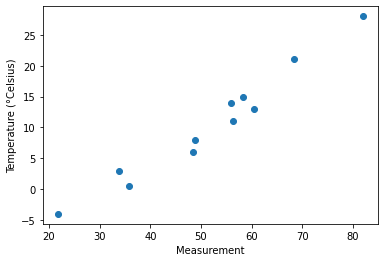

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt

In the absence of further knowledge, we assume the simplest possible model for converting between the two sets of measurements.

The two may be linearly related—that is, multiplying `t_u` by a factor and adding a constant, we may get the temperature in Celsius (up to an error that we omit):

```
t_c = w * t_u + b
```

(looks just like `y = mx + b`, `m` being the `slope` and `b` being the `coefficient`)

We chose to name `w` and `b` after `weight` and `bias`, two very common terms for linear scaling and the additive constant.

Now we need to estimate `w` and `b`, the parameters in our model, based on the data we have. We must do it so that temperatures we obtain from running the unknown temperatures `t_u` through the model are close to temperatures we actually measured in Celsius. If that sounds like fitting a line through a set of measurements, well, yes, because that’s exactly what we’re doing. We’ll go through this simple example using PyTorch and realize that training a neural network will essentially involve changing the model for a slightly more elaborate one, with a few (or a metric ton) more parameters.

To summarise, we have a model with some unknown parameters, and we need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible. We notice that we still need to exactly define a measure of the error. Such a measure, which we refer to as the loss function, should be high if the error is high and should ideally be as low as possible for a perfect match. Our optimization process should therefore aim at finding `w` and `b` so that the *loss
function* is at a minimum.

## Loss functions

A *loss function* (or *cost function*) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples. In our case, that would be the difference between the predicted temperatures `t_p` output by our model and the actual measurements `t_c` =>  `t_p – t_c`

We need to make sure the *loss function* makes the loss positive both when `t_p` is greater than and when it is less than the true `t_c`, since the goal is for `t_p` to match `t_c`. We have a few choices, the most straightforward being `|t_p – t_c|` and `(t_p – t_c)^2`. Based on the mathematical expression we choose, we can emphasize or discount certain errors. Conceptually, a *loss function* is a way of prioritizing which errors to fix from our training samples, so that our parameter updates result in adjustments to the outputs for the highly weighted samples instead of changes to some other samples output that had a smaller loss.


Both of the example loss functions have a clear minimum at zero and grow monotonically as the predicted value moves further from the true value in either direction.

Because the steepness of the growth also monotonically increases away from the minimum, both of them are said to be *convex*. Since our model is linear, the loss as a function of `w` and `b` is also *convex*. 

We’ve already created our data tensors, so now let’s write out the model as a Python function:



In [ ]:
def model(t_u, w, b):
  return (t_u * w) + b


We’re expecting `t_u`, `w`, and `b` to be the *input tensor*, *weight parameter*, and *bias parameter*, respectively.

In our model, the parameters will be PyTorch scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield
the returned tensors.

Let's define our loss:

In [3]:
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()


Note that we are building a tensor of differences, taking their square element-wise, and finally producing a scalar loss function by averaging all of the elements in the resulting tensor. It is a **mean square loss**.


We can now initialize the parameters and invoke the model:

In [ ]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

At this point, `t_p` is the same as `t_u` because all weights are `1` and biases are `0`.

This will change once we update `t_p`'s values with the help of our *loss function*:

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

## Decreasing loss

We’ll optimize the loss function with respect to the parameters using the gradient descent algorithm.

The idea of **Gradient Descent** is to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss.

We can estimate the rate of change along each parameter by adding a small number to `w` and `b` and seeing how much the loss changes in that neighborhood:



In [ ]:
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
loss_rate_of_change_w

tensor(4517.2979)

This is saying that in the neighborhood of the current values of `w` and `b`, a unit increase in `w` leads to some change in the loss. If the change is negative, then we need to increase `w` to minimize the loss, whereas if the change is positive, we need to decrease `w`. By how much? Applying a change to `w` that is proportional to the rate of change of the loss is a good idea, especially when the loss has several parameters: we apply a change to those that exert a significant change on the loss. It is also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current `w` value. Therefore, we typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is `learning_rate`:

In [ ]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

We can do the same with `b`:

In [ ]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b


This represents just **one** basic parameter-update step for gradient descent. By reiterating these evaluations (and provided we choose a small enough learning rate), we will converge to an optimal value of the parameters for which the loss computed on the given data is minimal. We’ll show the complete iterative process soon, but the way we just computed our rates of change is rather crude and needs an upgrade before we move on. Let’s see why and how.

## Getting analytical


Computing the rate of change by using repeated evaluations of the model and loss in order to probe the behavior of the loss function in the neighborhood of `w` and `b` doesn’t scale well to models with many parameters. Also, it is not always clear how large the neighborhood should be. We chose `delta` equal to `0.1` in the previous section, but it all depends on the shape of the loss as a function of `w` and `b`. If the loss changes too quickly compared to delta, we won’t have a very good idea of in which direction the loss is decreasing the most.

What if we could make the neighborhood infinitesimally small? That’s exactly what happens when we analytically take the derivative of the loss with respect to a parameter. In a model with two or more parameters like the one we’re dealing with, we compute the individual derivatives of the loss with respect to each parameter and put them in a vector of derivatives: the *gradient*.

### Computing the Derivatives

In order to compute the derivative of the loss with respect to a parameter, we can apply the chain rule and compute the derivative of the loss with respect to its input (which is the output of the model), times the derivative of the model with respect to the parameter.

Output of model `w * t_u + b` is `t_p`, therefore

```
d(loss_fn)/dw = d(loss_fn)/d(w * t_u + b) * d(w * t_u + b)/dw
```
becomes 
```
d(loss_fn)/dw = d(loss_fn)/d(t_p) * d(t_p)/dw
```



Recall that our model is a linear function, and our loss is a sum of squares. Let’s figure out the expressions for the derivatives. Recalling the expression for the loss:



```
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()
```

Remembering that `d(x^2) / dx = 2x`, we get

In [ ]:
def dloss_fn(t_p, t_c):
  dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) #The division is from the derivative of mean.
  return dsq_diffs

### Applying the derivatives to the model

For the model, recalling that our model is

```
def model(t_u, w, b):
    return w * t_u + b
```

we get these derivatives:


`d(w * t_u + b) / dw = t_u`

`d(w * t_u + b) / db = 1`


In [ ]:
def dmodel_dw(t_u, w, b):
  return t_u

In [ ]:
def dmodel_db(t_u, w, b):
  return 1.0

### Defining the **Gradient Function**

We take derivatives of the loss function with respect to `w` and `b`:

`d(loss_fn)/dw = d(loss_fn)/d(t_p) * d(t_p)/dw`

`d(loss_fn)/db = d(loss_fn)/d(t_p) * d(t_p)/db`

Putting all of this together, the function returning the gradient of the loss with respect to `w` and `b` is:

In [ ]:
def grad_fn(t_u, t_c, t_p, w, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
  return torch.stack([dloss_dw.sum(), dloss_db.sum()])

The summation `dloss_dw.sum()` and `dloss_db.sum()` is the reverse of the broadcasting we implicitly do when applying the parameters to an entire vector of inputs in the model.

We’re averaging (that is, summing and dividing by a constant) over all the data points to get a single scalar quantity for each partial derivative of the loss.

## Iterating to fit the model


We now have everything in place to optimize our parameters. Starting from a tentative value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until `w` and `b` stop changing. There are several stopping criteria; for now, we’ll stick to a fixed number of iterations.

### The Training Loop

Let’s introduce another piece of terminology. We call a training iteration during which we update the parameters for all of our training samples an **epoch**.

The complete training loop looks like this [(code/p1ch5/1_parameter_estimation.ipynb)](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch5/1_parameter_estimation.ipynb):



In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
  for epoch in range(1, n_epochs + 1):
    w, b = params
    t_p = model(t_u, w, b) #Forward Pass
    loss = loss_fn(t_p, t_c)
    grad = grad_fn(t_u, t_c, t_p, w, b) #Backward Pass
    params = params - learning_rate * grad

    if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # verbose printing
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
    if epoch in {4, 12, 101}:
        print('...')

    if not torch.isfinite(loss).all():
        break  # end of verbose printing

  return params

Let’s invoke our training loop:

In [ ]:
training_loop(
  n_epochs = 100,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0]), t_u = t_u,
  t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 5802485.500000
    Params: tensor([2568.4014,   45.1637])
    Grad:   tensor([-261257.4219,   -4598.9712])
Epoch 3, Loss 19408035840.000000
    Params: tensor([-148527.7344,   -2616.3933])
    Grad:   tensor([15109614.0000,   266155.7188])
...
Epoch 10, Loss 90901154706620645225508955521810432.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

### Overtraining

What happened? Our training process literally blew up, leading to losses becoming `inf`. This is a clear sign that params is receiving updates that are too large, and their values start oscillating back and forth as each update overshoots and the next overcorrects even more. The optimization process is unstable: it *diverges* instead of *converging* to a minimum. We want to see smaller and smaller updates to params, not larger.

How can we limit the magnitude of `learning_rate * grad`? We could simply choose a smaller `learning_rate`, and indeed, the `learning rate` is one of the things we typically change when training does not go as well as we would like. We usually change learning rates by orders of magnitude, so we might try with `1e-3` or `1e-4`, which would decrease the magnitude of the updates by orders of magnitude. Let’s go with `1e-4` and see how it works out:

In [ ]:
training_loop(
  n_epochs = 100,
  learning_rate = 1e-4,
  params = torch.tensor([1.0, 0.0]), t_u = t_u,
  t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122])
...
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022669
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

Nice—the behavior is now stable. But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could obviate this issue by making `learning_rate` adaptive: that is, change according to the magnitude of updates.


However, there’s another potential troublemaker in the update term: the *gradient* itself. Let’s go back and look at `grad` at `epoch 1` during optimization.

### Normalizing inputs

We can see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias. This means the weight and bias live in differently scaled spaces. If this is the case, a learning rate that’s large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that’s appropriate for the other won’t be large enough to meaningfully change the first. That means we’re not going to be able to update our parameters unless we change something about our formulation of the problem. We could have individual learning rates for each parameter, but for models with many parameters, this would be too much to bother with.

There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get too far from the range of `–1.0 to 1.0`, roughly speaking. In our case, we can achieve something close enough to that by simply multiplying `t_u` by `0.1`:

In [ ]:
t_un = 0.1 * t_u


Here, we denote the normalized version of `t_u` by appending an `n` to the variable name. At this point, we can run the training loop on our normalized input:

In [ ]:
training_loop(
  n_epochs = 100,
  learning_rate = 1e-2, #1e-2 instead of 1e-4
  params = torch.tensor([1.0, 0.0]), t_u = t_un, #t_un instead of t_u
  t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to `1e-2`, parameters don’t blow up during iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so using a single `learning_rate` for both parameters works just fine. We could probably do a better job of normalization than a simple rescaling by a factor of 10, but since doing so is good enough for our needs, we’re going to stick with that for now.

The normalization here absolutely helps get the network trained, but you could make an argument that it’s not strictly needed to optimize the parameters for this particular problem. That’s absolutely true! This problem is small enough that there are numerous ways to beat the parameters into submission. However, for larger, more sophisticated problems, normalization is an easy and effective (if not crucial!) tool to use to improve model convergence.

Let’s run the loop for enough iterations to see the changes in params get small. We’ll change `n_epochs` to `5,000`:

In [ ]:
params = training_loop(
  n_epochs = 5000,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0]),
  t_u = t_un,
  t_c = t_c,
  print_params = False)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


Good: our loss decreases while we change parameters along the direction of gradient descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to converge to zero, or that the data points don’t sit exactly on a line. As we anticipated, our measurements were not perfectly accurate, or there was noise involved in the reading.

But look: the values for `w` and `b` look an awful lot like the numbers we need to use to convert Celsius to Fahrenheit (after accounting for our earlier normalization when we multiplied our inputs by `0.1`). The exact values would be `w=5.5556` and `b=- 17.7778`. Our fancy thermometer was showing temperatures in Fahrenheit the whole time. No big discovery, except that our gradient descent optimization process works!

### Visualizing (again)

Let’s revisit something we did right at the start: plotting our data. This is the first thing anyone doing data science should do. Always plot the data!

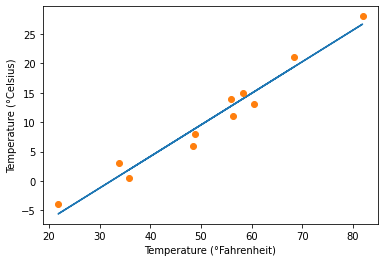

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
t_p = model(t_un, *params)
#fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

We are using a Python trick called argument unpacking here: `*params` means to pass the elements of `params` as individual arguments. In Python, this is usually done with lists or tuples, but we can also use argument unpacking with PyTorch tensors, which are split along the leading dimension. So here, `model(t_un, *params)` is equivalent to `model(t_un, params[0], params[1])`.

## PyTorch’s autograd: Backpropagating all things


In our little adventure, we just saw a simple example of backpropagation: we computed the gradient of a composition of functions—the model and the loss—with respect to their innermost parameters (w and b) by propagating derivatives backward using the chain rule. The basic requirement here is that all functions we’re dealing with can be differentiated analytically. If this is the case, we can compute the gradient—what we earlier called “the rate of change of the loss”—with respect to the parameters in one sweep.
Even if we have a complicated model with millions of parameters, as long as our model is differentiable, computing the gradient of the loss with respect to the parameters amounts to writing the analytical expression for the derivatives and evaluating
them once. Granted, writing the analytical expression for the derivatives of a very deep 9
composition of linear and nonlinear functions is not a lot of fun. It isn’t particularly quick, either.

### Computing the gradient automatically


This is when PyTorch tensors come to the rescue, with a PyTorch component called **autograd**. Chapter 3 presented a comprehensive overview of what tensors are and what functions we can call on them. We left out one very interesting aspect, however: PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs. This means we won’t need to derive our model by hand; given a forward expression, no matter how nested, PyTorch will automatically provide the gradient of that expression with respect to its input parameters.


### Applying Autograd

At this point, the best way to proceed is to rewrite our thermometer calibration code, this time using autograd, and see what happens. First, we recall our model and loss function [(code/p1ch5/2_autograd.ipynb)](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch5/2_autograd.ipynb):

```
def model(t_u, w, b):
  return w * t_u + b

def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()
```

Let’s initialise a parameters tensor:


In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

### Using the `requires_grad` attribute

Notice the `requires_grad=True` argument to the tensor constructor? That argument is telling PyTorch to track the entire family tree of tensors resulting from operations on params. In other words, any tensor that will have params as an ancestor will have access to the chain of functions that were called to get from params to that tensor. In case these functions are differentiable (and most PyTorch tensor operations will be), the value of the derivative will be automatically populated as a grad attribute of the params tensor.


In general, all PyTorch tensors have an attribute named grad. Normally, it’s None:

In [ ]:
params.grad is None

True

All we have to do to populate it is to start with a tensor with `requires_grad` set to `True`, then call the model and compute the loss, and then call backward on the loss tensor:


In [ ]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

At this point, the `grad` attribute of `params` contains the derivatives of the loss with respect to each element of `params`.


When we compute our loss while the parameters `w` and `b` require gradients, in addition to performing the actual computation, PyTorch creates the autograd graph with the operations. When we call `loss.backward()`, PyTorch traverses this graph in the reverse direction to compute the gradients.

Only those tensors with `requires_grad` set to `True` will get their `grad` values populated.

### Accumulating Grad Functions

We could have any number of tensors with requires_grad set to True and any composition of functions. In this case, PyTorch would compute the derivatives of the loss throughout the chain of functions (the computation graph) and accumulate their values in the grad attribute of those tensors (the leaf nodes of the graph).

Alert! **Big gotcha ahead**. This is something PyTorch newcomers—and a lot of more experienced folks, too—trip up on regularly. We just wrote *accumulate*, not *store*. Calling `backward()` will lead derivatives to *accumulate* at leaf nodes. We need to zero the gradient explicitly after using it for parameter updates.


So if `backward()` was called earlier, the loss is evaluated again, `backward()` is called again (as in any training loop), and the gradient at each leaf is accumulated (that is, summed) on top of the one computed at the previous iteration, which leads to an incorrect value for the gradient. In order to prevent this from occurring, we need to `zero` the gradient explicitly at each iteration. We can do this easily using the in-place `zero_` method:


In [ ]:
if params.grad is not None:
  params.grad.zero_()

There is a reason why zeroing the gradient is a required step instead of zeroing happening automatically whenever we call backward. Doing it this way provides more flexibility and control when working with gradients in complicated models.

Now, let’s see what our autograd-enabled training code looks like, start to finish:

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None: #This could be done at any point in the loop prior to calling loss.backward().
      params.grad.zero_()

    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    loss.backward()

    with torch.no_grad():
      params -= learning_rate * params.grad

    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))

  return params

Note that our code updating params is not quite as straightforward as we might have expected. There are two particularities. First, we are encapsulating the update in a `no_grad` context using the Python `with` statement. This means within the `with` block, the PyTorch autograd mechanism should look away: that is, not add edges to the forward graph. In fact, when we are executing this bit of code, the forward graph that PyTorch records is consumed when we call backward, leaving us with the params leaf node. But now we want to change this leaf node before we start building a fresh forward graph on top of it.

Second, we update `params` in place. This means we keep the same `params` tensor around but subtract our update from it. When using autograd, we usually avoid in- place updates because PyTorch’s autograd engine might need the values we would be modifying for the backward pass. Here, however, we are operating without autograd, and it is beneficial to keep the `params` tensor. Not replacing the parameters by assigning new tensors to their variable name will become crucial when we register our parameters with the optimizer.

Let’s invoke our loop:

In [ ]:
training_loop(
  n_epochs = 5000,
  learning_rate = 1e-2,
  params = torch.tensor([1.0, 0.0],requires_grad=True), #notice requires_grad=True
  t_u = t_un, #normalised units
  t_c = t_c
)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

The result is the same as we got previously. Good for us! It means that while we are capable of computing derivatives by hand, we no longer need to.

## Optimizers

In the example code, we used *vanilla* gradient descent for optimization, which worked fine for our simple case. Needless to say, there are several optimization strategies and tricks that can assist convergence, especially when models get complicated.
We’ll dive deeper into this topic in later chapters, but now is the right time to introduce the way PyTorch abstracts the optimization strategy away from user code: that is, the training loop we’ve examined. This saves us from the boilerplate busywork of having to update each and every parameter to our model ourselves. The torch module has an `optim` submodule where we can find classes implementing different optimization algorithms. Here’s an abridged list
[(code/p1ch5/3_optimizers.ipynb)](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch5/3_optimizers.ipynb) :


In [5]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']


Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically with `requires_grad` set to `True`) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values after each `backward()` call and access their `grad` attribute.


Each optimizer exposes two methods: `zero_grad` and `step`. `zero_grad` zeroes the `grad` attribute of all the parameters passed to the optimizer upon construction. `step` updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

### Using a Gradient Descent Optimizer

Let’s create `params` and instantiate a gradient descent optimizer:

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Here **SGD** stands for *stochastic gradient descent*. Actually, the optimizer itself is exactly a vanilla gradient descent (as long as the momentum argument is set to `0.0`, which is the default). The term stochastic comes from the fact that the gradient is typically obtained by averaging over a random subset of all input samples, called a *minibatch*. However, the optimizer does not know if the loss was evaluated on all the samples (*vanilla*) or a random subset of them (*stochastic*), so the algorithm is literally the same in the two cases.

In [ ]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of params is updated upon calling `step()` without us having to touch it ourselves! What happens is that the optimizer looks into `params.grad` and updates `params`, subtracting `learning_rate * grad` from it, exactly as in our former handwritten code.


Ready to stick this code in a training loop? Nope! The big gotcha almost got us— we forgot to zero out the gradients. Had we called the previous code in a loop, gradients would have accumulated in the leaves at every call to backward, and our gradient descent would have been all over the place! Here’s the loop-ready code, with the extra `zero_grad` at the correct spot (right before the call to backward):

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad() #zero_grad
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

Perfect! See how the `optim` module helps us abstract away the specific optimization scheme? All we have to do is provide a list of `params` to it (that list can be extremely long, as is needed for very deep neural network models).

Let’s update our training loop accordingly:


In [ ]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))

  return params

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860118
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927680
Epoch 4500, Loss 2.927651
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012], requires_grad=True)

### Testing other Optimizers

In order to test more optimizers, all we have to do is instantiate a different optimizer, say Adam, instead of SGD. The rest of the code stays as it is.

We won’t go into much detail about Adam; suffice to say that it is a more sophisticated optimizer in which the learning rate is set adaptively. In addition, it is a lot less sensitive to the scaling of the parameters—so insensitive that we can go back to using the original (non-normalized) input `t_u`, and even increase the learning rate to `1e-1`, and Adam won’t even blink:

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

training_loop(n_epochs=2000,
              optimizer=optimizer,
              params=params,
              t_u = t_u,
              t_c = t_c)

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

Notice how the first element of params is `0.5367` instead of the usual `5.3671`. This is because we used `t_u` instead of the normalized `t_un`.

The optimizer is not the only flexible part of our training loop. Let’s turn our attention to the model. In order to train a neural network on the same data and the same loss, all we would need to change is the model function. It wouldn’t make particular sense in this case, since we know that converting Celsius to Fahrenheit amounts to a linear transformation.

 We’ll see quite soon that neural networks allow us to remove our arbitrary assumptions about the shape of the function we should be approximating. Even so, we’ll see how neural networks manage to be trained even when the underlying processes are highly nonlinear (such in the case of describing an image with a sentence, as we saw in chapter 2).


We have touched on a lot of the essential concepts that will enable us to train complicated deep learning models while knowing what’s going on under the hood: backpropagation to estimate gradients, autograd, and optimizing weights of models using gradient descent or other optimizers.


Next, we’re going to offer an aside on how to split our samples, because that sets up a perfect use case for learning how to better control autograd.


## Training, validation, and overfitting

We need to keep a part of the data on the side so that we can validate our models on independent observations. This is a vital thing to do, especially when the model we adopt could potentially approximate functions of any shape, as in the case of neural networks. In other words, a highly adaptable model will tend to use its many parameters to make sure the loss is minimal *at* the data points, but we’ll have no guarantee that the model behaves well *away from or in between* the data points.

After all, that’s what we’re asking the optimizer to do: minimize the loss *at* the data points. Sure enough, if we had independent data points that we didn’t use to evaluate our loss or descend along its negative gradient, we would soon find out that evaluating the loss at those independent data points would yield higher-than-expected loss. We have already mentioned this phenomenon, called **overfitting**.

The first action we can take to combat overfitting is recognizing that it might hap- pen. In order to do so, as Kepler figured out in 1600, we must take a few data points out of our dataset (the *validation* set) and only fit our model on the remaining data points (the *training* set). Then, while we’re fitting the model, we can evaluate the loss once on the training set and once on the validation set. When we’re trying to decide if we’ve done a good job of fitting our model to the data, we must look at both!

A deep neural network can potentially approximate complicated functions, provided that the number of neurons, and therefore parameters, is high enough. The fewer the number of parameters, the simpler the shape of the function our network will be able to approximate.


So, **rule 1**: if the training loss is not decreasing, chances are the model is too simple for the data. The other possibility is that our data just doesn’t contain meaningful information that lets it explain the output: if the nice folks at the shop sell us a barometer instead of a thermometer, we will have little chance of predicting temperature in Celsius from just pressure.

**rule 2**: if the training loss and the validation loss diverge, we’re overfitting. If the loss evaluated in the validation set doesn’t decrease along with the training set, it means our model is improving its fit of the samples it is seeing during training, but it is not generalizing to samples outside this precise set.If we evaluate the model at new, previously unseen points, the values of the loss function can be poor.

We’ve got some nice trade-offs here. On the one hand, we need the model to have enough capacity for it to fit the training set. On the other, we need the model to avoid overfitting. Therefore, in order to choose the right size for a neural network model in terms of parameters, the process is based on two steps: increase the size until it fits, and then scale it down until it stops overfitting.

Let’s get back to our example and see how we can split the data into a training set and a validation set. We’ll do it by shuffling `t_u` and `t_c` the same way and then splitting the resulting shuffled tensors into two parts.

### Splitting a Dataset

Shuffling the elements of a tensor amounts to finding a permutation of its indices. The `randperm` function does exactly this:

In [ ]:
n_samples = t_u.shape[0] #size of whole sample set
n_val = int(0.2 * n_samples) #size of validation set
shuffled_indices = torch.randperm(n_samples) #shuffle
train_indices = shuffled_indices[:-n_val] #training set
val_indices = shuffled_indices[-n_val:] #validation set
train_indices, val_indices


(tensor([ 3,  0,  2,  9,  8, 10,  4,  1,  6]), tensor([5, 7]))

We just got index tensors that we can use to build training and validation sets starting
from the data tensors:

In [ ]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u #normalised
val_t_un = 0.1 * val_t_u #normalised

Our training loop doesn’t really change. We just want to additionally evaluate the validation loss at every epoch, to have a chance to recognize whether we’re overfitting:

In [ ]:
def training_loop(n_epochs, optimizer, params, train_t_u,
                  val_t_u, train_t_c, val_t_c):
  
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

Note that there is no `val_loss.backward()` here because we don't want to train our model on our validation data.

Since we’re using Stochastic Gradient Descent again, we’re back to using normalized inputs.

In [ ]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 92.9048, Validation loss 23.9323
Epoch 2, Training loss 32.4664, Validation loss 36.4383
Epoch 3, Training loss 25.9949, Validation loss 46.3535
Epoch 500, Training loss 9.8406, Validation loss 11.4031
Epoch 1000, Training loss 5.1131, Validation loss 2.0225
Epoch 1500, Training loss 3.6758, Validation loss 0.9233
Epoch 2000, Training loss 3.2388, Validation loss 1.5555
Epoch 2500, Training loss 3.1059, Validation loss 2.2806
Epoch 3000, Training loss 3.0655, Validation loss 2.7949


tensor([  5.5415, -18.3099], requires_grad=True)

Here we are not being entirely fair to our model. The validation set is really small, so the validation loss will only be meaningful up to a point. In any case, we note that the validation loss is **lesser** (in the textbook, we get a higher validation loss) than our training loss, although not by an order of magnitude.

We expect a model to perform better on the training set, since the model parameters are being shaped by the training set. Our main goal is to also see both the training loss and the validation loss decreasing. While ideally both losses would be roughly the same value, as long as the validation loss stays reasonably close to the training loss, we know that our model is continuing to learn generalized things about our data.



### Autograd nits and switching it off

From the previous training loop, we can appreciate that we only ever call backward on `train_loss`. Therefore, errors will only ever backpropagate based on the training set—the validation set is used to provide an independent evaluation of the accuracy of the model’s output on data that wasn’t used for training.


The curious reader will have a question at this point. The model is evaluated twice—once on train_t_u and once on val_t_u—and then backward is called. Won’t this confuse autograd? Won’t backward be influenced by the values generated during the pass on the validation set?


Luckily for us, this isn’t the case. The first line in the training loop evaluates model on `train_t_u` to produce `train_t_p`. Then `train_loss` is evaluated from `train_t_p`. This creates a computation graph that links `train_t_u` to `train_t_p` to `train_loss`.

When model is evaluated again on `val_t_u`, it produces `val_t_p` and `val_loss`. In this case, a separate computation graph will be created that links `val_t_u` to `val_t_p` to `val_loss`. Separate tensors have been run through the same functions, `model` and `loss_fn`, generating separate computation graphs.


The only tensors these two graphs have in common are the parameters. When we call backward on `train_loss`, we run backward on the first graph. In other words, we accumulate the derivatives of `train_loss` with respect to the parameters based on the computation generated from `train_t_u`.

If we (incorrectly) called backward on `val_loss` as well, we would accumulate the derivatives of `val_loss` with respect to the parameters on the same leaf nodes. Remember the `zero_grad` thing, whereby gradients are accumulated on top of each other every time we call backward unless we zero out the gradients explicitly? Well, here something very similar would happen: calling backward on `val_loss` would lead to gradients accumulating in the `params` tensor, on top of those generated during the `train_loss.backward()` call. In this case, we would effectively train our model on the whole dataset (both training and validation), since the gradient would depend on both - which is effectively the same as what we did earlier.

Since we’re not ever calling `backward()` on `val_loss`, why are we building the graph in the first place? We could in fact just call `model` and `loss_fn` as plain functions, without tracking the computation. However optimized, building the autograd graph comes with additional costs that we could totally forgo during the validation pass, especially when the model has millions of parameters.

In order to address this, PyTorch allows us to switch off autograd when we don’t need it, using the `torch.no_grad` context manager. We won't see any meaningful advantage in terms of speed or memory consumption on our small problem. However, for larger models, the differences can add up. We can make sure this works by checking the value of the `requires_grad` attribute on the `val_loss` tensor:

In [ ]:
def training_loop(n_epochs, optimizer, params, train_t_u,
                  val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): #Context Manager here
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False #Checks that our output requires_grad args are forced to False inside this block
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

Using the related `set_grad_enabled` context, we can also condition the code to run with `autograd` enabled or disabled, according to a Boolean expression —typically indicating whether we are running in *training* or *inference* mode. We could, for instance, define a `calc_forward` function that takes data as input and runs `model` and `loss_fn` with or without autograd according to a Boolean `train_is` argument:

In [ ]:
def calc_forward(t_u, t_c, is_train):
  with torch.set_grad_enabled(is_train):
    t_p = model(t_u, *params)
    loss = loss_fn(t_p, t_c)
  return loss

# Conclusion

We started this chapter with a big question: how is it that a machine can learn from examples? We spent the rest of the chapter describing the mechanism with which a model can be optimized to fit data. We chose to stick with a simple model in order to see all the moving parts without unneeded complications.

Now that we’ve had our fill of appetizers, in chapter 6 we’ll finally get to the main course: using a neural network to fit our data. We’ll work on solving the same thermometer problem, but with the more powerful tools provided by the `torch.nn` module. We’ll adopt the same spirit of using this small problem to illustrate the larger uses of PyTorch. The problem doesn’t need a neural network to reach a solution, but it will allow us to develop a simpler understanding of what’s required to train a neural network.

#Exercises

1. Redefine the model to be `w2 * t_u ** 2 + w1 * t_u + b`.

a. What parts of the training loop, and so on, need to change to accommodate this redefinition?

 We see that the model is a polynomial function, instead of linear in our last example. This means we have more paramaters to backpropogate - `w2`, `w1`, and `b`. Therefore we will have to change the `params` tensor in the training loop.

 b.  What parts are agnostic to swapping out the model?

 The `learning_rate` and the numbers of `epoch`'s will be agnostic to swapping out the model.

 c. Is the resulting loss higher or lower after training?

In [6]:
def exercise_model(t_u, w1, w2, b):
  return w2 * (t_u ** 2) + w1 * t_u + b

def exercise_training_loop(n_epochs, optimizer, params, t_u, t_c):
  for epoch in range(1, n_epochs + 1):
    t_p = exercise_model(t_u, *params)
    loss = loss_fn(t_p, t_c)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))

  return params

exercise_params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True) #w1, w2, b
learning_rate = 1e-2
optimizer = optim.Adam([exercise_params], lr=learning_rate)

exercise_training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = exercise_params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 6.108696
Epoch 1000, Loss 5.984359
Epoch 1500, Loss 5.809034
Epoch 2000, Loss 5.586318
Epoch 2500, Loss 5.320904
Epoch 3000, Loss 5.021268
Epoch 3500, Loss 4.701310
Epoch 4000, Loss 4.380754
Epoch 4500, Loss 4.083410
Epoch 5000, Loss 3.832654


tensor([-0.0698,  0.0054, -1.2251], requires_grad=True)

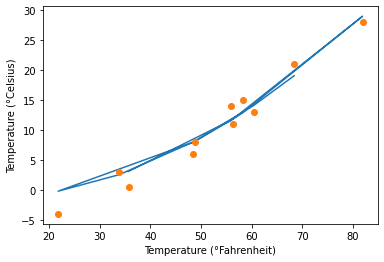

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
t_p = exercise_model(t_u, *exercise_params)
#fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

The resulting loss is higher after training.


c. Is the actual result better or worse?

The actual result is worse. This is expected because we are using a polynomial function to fit a linear model.

# Summary

- Linear models are the simplest reasonable model to use to fit data.
- Convex optimization techniques can be used for linear models, but they do not generalize to neural networks, so we focus on stochastic gradient descent for
parameter estimation.
- Deep learning can be used for generic models that are not engineered for solving a specific task, but instead can be automatically adapted to specialize themselves on the problem at hand.
- Learning algorithms amount to optimizing parameters of models based on observations. A loss function is a measure of the error in carrying out a task, such as the error between predicted outputs and measured values. The goal is to get the loss function as low as possible.
- The rate of change of the loss function with respect to the model parameters can be used to update the same parameters in the direction of decreasing loss.
- The `optim` module in PyTorch provides a collection of ready-to-use optimizers for updating parameters and minimizing loss functions.
- Optimizers use the `autograd` feature of PyTorch to compute the gradient for each parameter, depending on how that parameter contributes to the final output. This allows users to rely on the dynamic computation graph during complex forward passes.
-Context managers like with `torch.no_grad()`: can be used to control `autograd`’s behavior.
-Data is often split into separate sets of *training* samples and *validation* samples. This lets us evaluate a model on data it was not trained on.
-Overfitting a model happens when the model’s performance continues to improve on the training set but degrades on the validation set. This is usually due to the model not generalizing, and instead memorizing the desired outputs for the training set.